In [19]:
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *


## NSRBD Data for Site in Year/Month

In [20]:
DATA_YEAR = 2016
DATA_MONTH = 6
site = SITES['Fort Ross']

ghi_year = get_nsrdb_data(DATA_YEAR, 'ghi', site['nsrdb_site_id'], site['tz'])
month_filter = f'{DATA_YEAR}-{DATA_MONTH}'
ghi_month = ghi_year[month_filter]

Found cached/site-131123-data-2016.pkl, loading...


### Chart GHI for Month

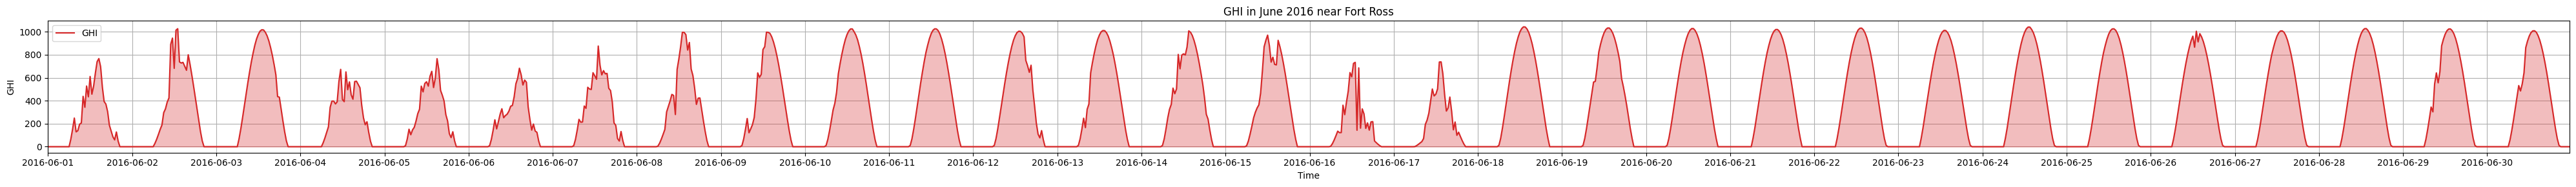

In [21]:
plt.figure(figsize=(40, 3))
plt.plot(ghi_month.index, ghi_month, label='GHI', color='tab:red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])

plt.fill_between(ghi_month.index, ghi_month.min(), ghi_month, color='tab:red', alpha=0.3, zorder=2)

# Set title using the first index's month and year, dynamically adjusting to the displayed data
plt.title(f'GHI in {ghi_month.index[0].month_name()} {ghi_month.index[0].year} near Fort Ross')
plt.xlabel('Time')
plt.ylabel('GHI')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Get Tide Predictions and Interpolate

In [22]:
month_padded = get_month_padded(DATA_YEAR, DATA_MONTH)
tide_series = get_noaa_tide_preds(site, month_padded)
tide_high_res = interpolate_tide_preds(tide_series, ghi_month.index)

## Chart Tide and Sun Overlaid

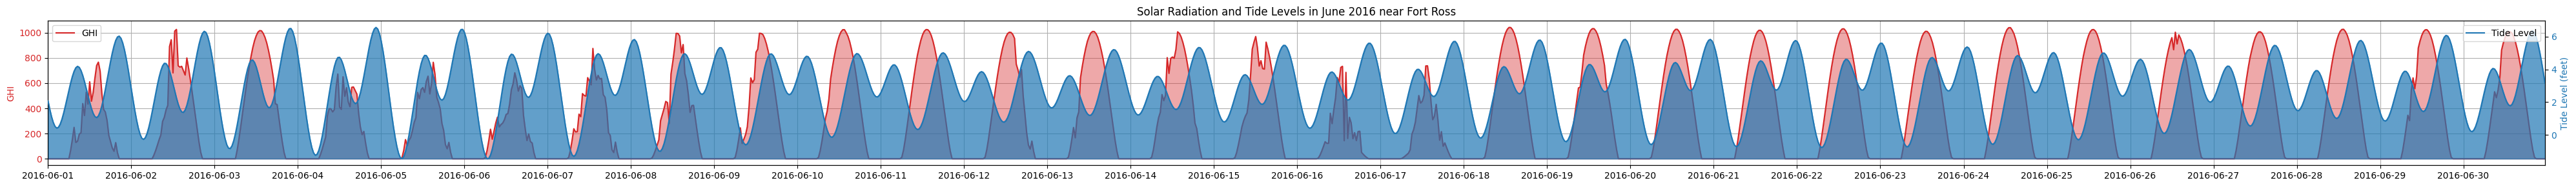

In [23]:
fig, ax1 = plt.subplots(figsize=(40, 3))

# Plot GHI data
ax1.plot(ghi_month.index, ghi_month, label='GHI', color='tab:red', zorder=3)
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])
ax1.set_ylabel('GHI', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Shade the area below the GHI line
ax1.fill_between(ghi_month.index, ghi_month.min(), ghi_month, color='tab:red', alpha=0.4, zorder=2)

# Create a secondary y-axis for tide data
ax2 = ax1.twinx()
ax2.plot(ghi_month.index, tide_high_res, label='Tide Level', color='tab:blue', linestyle='-', zorder=4)
ax2.set_ylabel('Tide Level (feet)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Shade the area above the tide line
ax2.fill_between(ghi_month.index, tide_high_res.min(), tide_high_res, color='tab:blue', alpha=0.7, zorder=1)

# Title, grid, and legend
ax1.set_title(f"Solar Radiation and Tide Levels in {ghi_month.index[0].strftime('%B %Y')} near Fort Ross")
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


## Graph Tide-Scaled Radiation

### Normalize Tide Data
We want to scale the solar radiation according to how low the tide was, so with our tide data currently in the range 0-1 where 0 is the lowest tide, we need to invert that so 0 is the highest tide, meaning the least solar radiation is getting absorbed.

In [24]:
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

tide_values_inverted = 1 - tide_values_normalized

assert tide_values_inverted.shape == ghi_month.shape
tide_scaled_ghi = tide_values_inverted * ghi_month

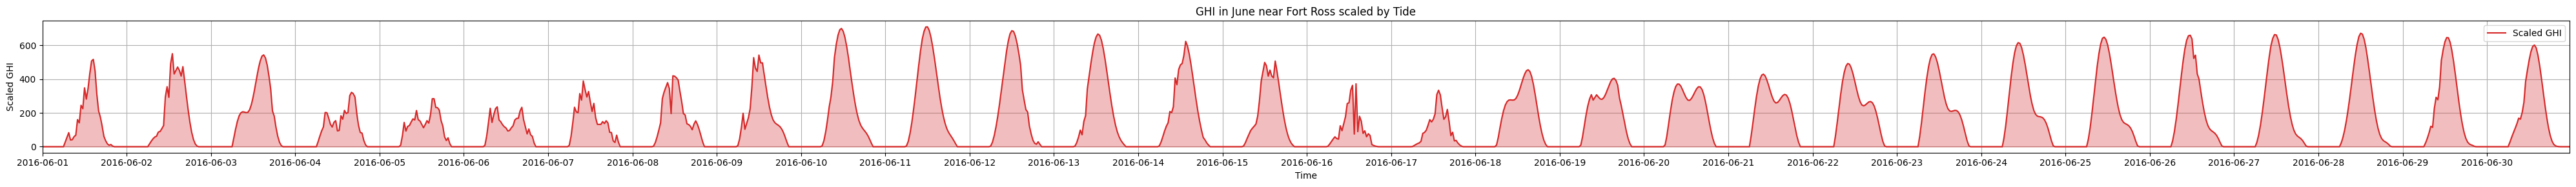

In [25]:
plt.figure(figsize=(40, 3))

# day_time_index_utc = day_time_index.tz_convert('UTC')
# plt.plot(day_time_index_utc, day_tseries, label='GHI')
plt.plot(ghi_month.index, tide_scaled_ghi, label='Scaled GHI', color='tab:red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])

plt.fill_between(ghi_month.index, tide_scaled_ghi.min(), tide_scaled_ghi, color='tab:red', alpha=0.3, zorder=2)

plt.title(f'GHI in {ghi_month.index[0].month_name()} near Fort Ross scaled by Tide')
plt.xlabel('Time')
plt.ylabel('Scaled GHI')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Graph Tide-Thresholded Radiation

In [26]:
TIDE_THRESHOLD = 0.50 # TODO where should this be from??
tide_thresholded_ghi = ghi_month * (tide_values_normalized < TIDE_THRESHOLD)

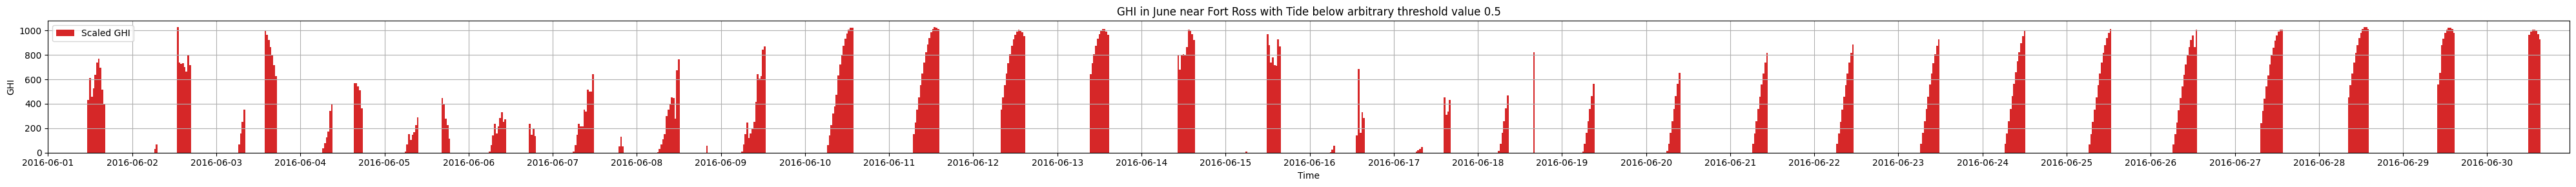

In [27]:
plt.figure(figsize=(40, 3))

# Calculating the width of each bar in days (assuming regular intervals)
if len(ghi_month.index) > 1:
    bar_width = (ghi_month.index[1] - ghi_month.index[0]).total_seconds() / (24 * 3600)
else:
    bar_width = 0.01  # default to a very small width if unable to calculate

plt.bar(ghi_month.index, tide_thresholded_ghi, width=bar_width, color='tab:red', label='Scaled GHI', align='center')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])

plt.title(f'GHI in {ghi_month.index[0].month_name()} near Fort Ross with Tide below arbitrary threshold value {TIDE_THRESHOLD}')
plt.xlabel('Time')
plt.ylabel('GHI')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Graph Both Overlaid

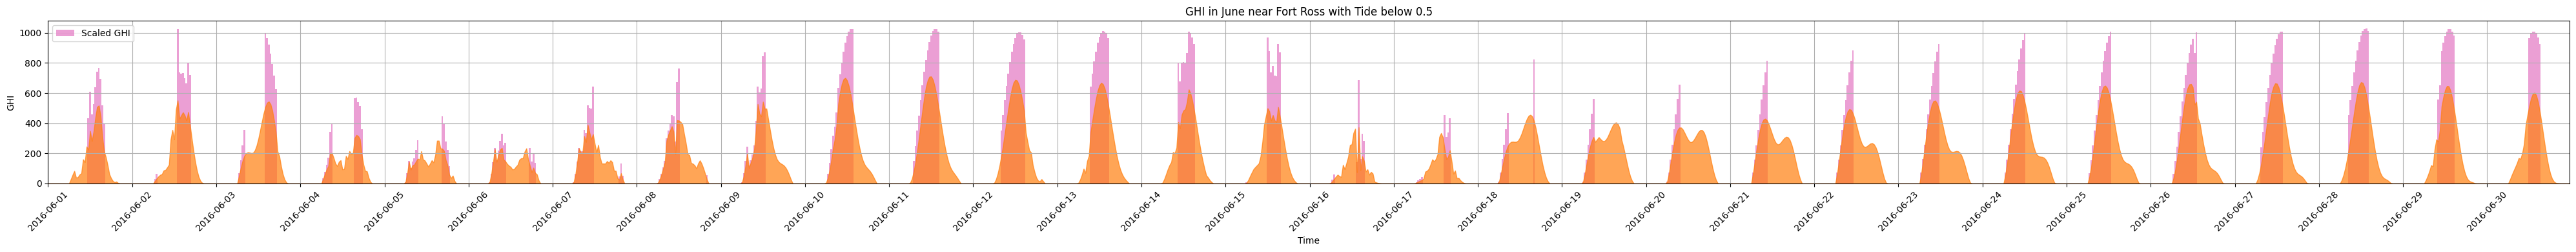

In [28]:
plt.figure(figsize=(40, 4))

# Calculating the width of each bar in days (assuming regular intervals)
if len(ghi_month.index) > 1:
    bar_width = (ghi_month.index[1] - ghi_month.index[0]).total_seconds() / (24 * 3600)
else:
    bar_width = 0.01  # default to a very small width if unable to calculate

plt.bar(ghi_month.index, tide_thresholded_ghi, width=bar_width, color='tab:pink', label='Scaled GHI', align='center', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])

plt.fill_between(ghi_month.index, tide_scaled_ghi.min(), tide_scaled_ghi, color='tab:orange', alpha=0.7)

plt.title(f'GHI in {ghi_month.index[0].month_name()} near Fort Ross with Tide below {TIDE_THRESHOLD}')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Aggregate by Days
TODO: Dates are off in the labels for some reason

In [29]:
DATA_GRANULARITY = 48 # 48 measurements per day; twice hourly

def aggregate_data(data_series):
    total_measurements = data_series.size
    if total_measurements % DATA_GRANULARITY != 0:
        raise ValueError("The number of measurements is not consistent with whole days")
    num_days = total_measurements // DATA_GRANULARITY

    reshaped_data = data_series.values.reshape((num_days, DATA_GRANULARITY))
    return np.sum(reshaped_data, axis=1)

daily_tide_thresholded_ghi = aggregate_data(tide_thresholded_ghi)
daily_tide_scaled_ghi = aggregate_data(tide_scaled_ghi)

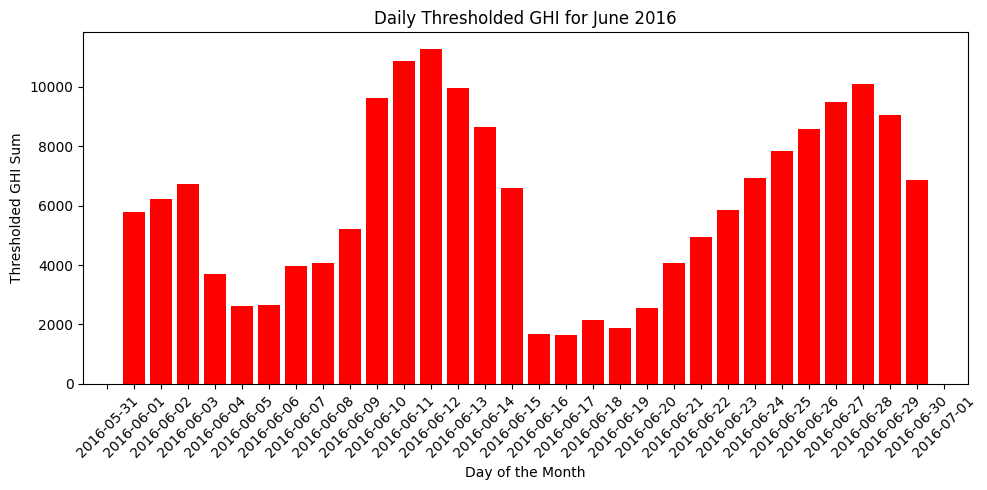

In [30]:
# Generate a date range for the month
plot_date_range = pd.date_range(start=f"{DATA_YEAR}-{DATA_MONTH}-1", periods=len(daily_tide_thresholded_ghi), freq='D', tz=site['tz'])

# Create the plot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(plot_date_range, daily_tide_thresholded_ghi, color='red')
plt.title(f'Daily Thresholded GHI for {plot_date_range[0].strftime("%B %Y")}')
plt.xlabel('Day of the Month')
plt.ylabel('Thresholded GHI Sum')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Improve the x-axis ticks to show each day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

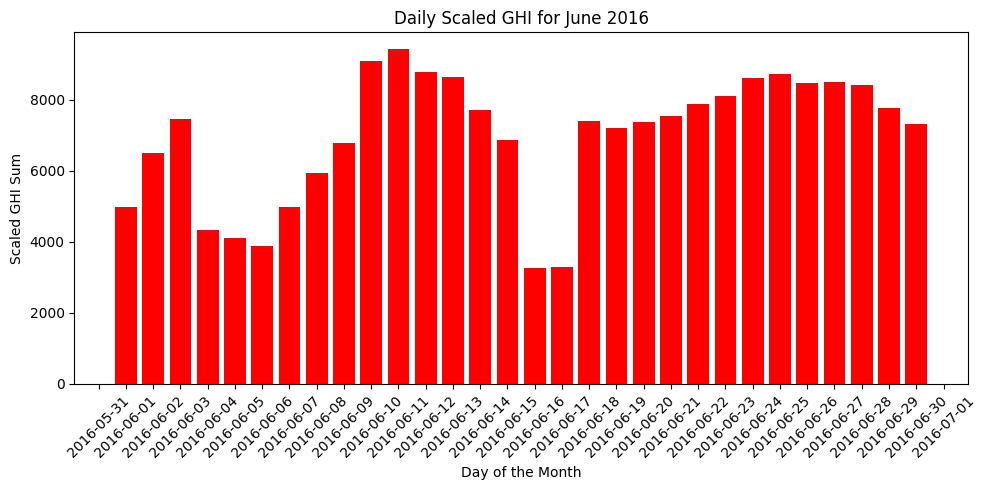

In [31]:
# Generate a date range for the month
plot_date_range = pd.date_range(start=f"{DATA_YEAR}-{DATA_MONTH}-1", periods=len(daily_tide_scaled_ghi), freq='D', tz=site['tz'])

# Create the plot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(plot_date_range, daily_tide_scaled_ghi, color='red')
plt.title(f'Daily Scaled GHI for {plot_date_range[0].strftime("%B %Y")}')
plt.xlabel('Day of the Month')
plt.ylabel('Scaled GHI Sum')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Improve the x-axis ticks to show each day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()